In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
from models import GNN_A3TGCN
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric import seed_everything

In [2]:
trafo_id = "T1330"
epochs = 1
num_timesteps_in = 12
num_timesteps_out = 4
test_ratio_vs_eval_ratio = 0.5
learning_rate = 0.01
device_str = 'cpu'
hidden = 64
manual_seed = 42

In [3]:
if device_str == 'cuda':
    torch.cuda.empty_cache()

In [4]:
seed_everything(manual_seed)

In [5]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
eval_dataset, test_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [6]:
def train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=None, epochs=10, name=""):
    """
    Definition of the training loop.
    """
    epoch_losses_train = []
    epoch_losses_eval = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0

        for snapshot_i in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot = loader.get_snapshot(snapshot_i)
            snapshot.to(device)
            optimizer.zero_grad()

            out = model(snapshot.x, snapshot.edge_index)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()

        if scheduler is not None:
            scheduler.step(epoch_loss_train)

        epoch_losses_train.append(epoch_loss_train)

        model.eval()
        epoch_loss_eval = 0
        with torch.no_grad():

            for snapshot_j in tqdm(eval_dataset, desc="Evaluating epoch {}".format(epoch)):
                snapshot = loader.get_snapshot(snapshot_j)
                snapshot.to(device)

                out = model(snapshot.x, snapshot.edge_index)

                loss = loss_fn()(out, snapshot.y).cpu().numpy()
                epoch_loss_eval += loss

            epoch_losses_eval.append(epoch_loss_eval)
            if min(epoch_losses_eval) == epoch_loss_eval:
                torch.save(model.state_dict(), name)
            print("Epoch: {}, Train Loss: {:.7f}, Eval Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_eval))
        
        
    return epoch_losses_train, epoch_losses_eval

In [7]:
device = torch.device(device_str)
model = GNN_A3TGCN(node_features=loader.num_features, periods=num_timesteps_out, hidden=hidden).to(device)



#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

name = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.pt"
name_txt = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.txt"


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
losses_train, losses_eval = train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=scheduler, epochs=epochs, name=name)


Evaluating epoch 0: 100%|██████████| 1440/1440 [00:18<00:00, 76.14it/s]

Epoch: 0, Train Loss: 1147.7666265, Eval Loss: 5621.8523886


In [8]:
std = loader.mean_and_std["measurements"][1]["voltage"]
mean = loader.mean_and_std["measurements"][0]["voltage"]

In [9]:
def eval(model, loader, test_dataset, device, loss_fn, std, mean):
    preds = []
    ys = []
    with torch.no_grad():
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        for snapshot_j in tqdm(test_dataset, desc="Evaluating"):
            snapshot = loader.get_snapshot(snapshot_j)
            snapshot = snapshot.to(device)
            
            out= model(snapshot.x, snapshot.edge_index)

            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()

            ys.append(snapshot.y.cpu().numpy()*std+mean)
            preds.append(out.cpu().numpy()*std+mean)
            
        loss_all *= std/len(test_dataset)
        loss_elementwise *= std/len(test_dataset)

        ys = np.stack(ys, axis=-1)
        preds = np.stack(preds, axis=-1)
    return loss_all, loss_elementwise, preds, ys

In [10]:
model.load_state_dict(torch.load(name))

<All keys matched successfully>

In [11]:
loss_fn = torch.nn.L1Loss

In [12]:
loss_test, loss_test_elementwise, preds, ys = eval(model, loader, test_dataset, device, loss_fn, std, mean)
loss_test_timewise = loss_test_elementwise.mean(axis=0)
print("Loss all: {:.7f}".format(loss_test))
print("Loss elementwise: {}".format(loss_test_elementwise))

Evaluating: 100%|██████████| 1440/1440 [00:23<00:00, 60.62it/s]

Loss all: 5.6183468
Loss elementwise: [[ 3.351673   3.499733   3.3168273  3.6106222]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.375614   5.584689   5.1558657  5.6640573]
 [ 5.387916   5.596928   5.16662    5.679131 ]
 [ 3.465952   3.6227534  3.4650896  3.7375214]
 [ 4.928495   5.119559   4.7035933  5.2005835]
 [ 4.6731663  4.875224   4.4890285  4.968923 ]
 [ 4.6672215  4.8415475  4.47444    4.9521675]
 [ 3.2435822  3.3856084  3.2302754  3.4905648]
 [ 4.579061   4.7513566  4.3961883  4.864925 ]
 [ 3.2784865  3.435693   3.3041372  3.5569403]
 [ 4.598235   4.7696567  4.4184527  4.8863063]
 [ 4.472866   4.6449213  4.302212   4.7590814]
 [ 4.925216   5.092022   4.759051   5.1963086]
 [ 3.171889   3.3006828  3.1513164  3.4315307]
 [ 5.264261   5.4514766  5.040547   5.537649 ]
 [ 3.2465417  3.393243

In [13]:
import matplotlib.pyplot as plt

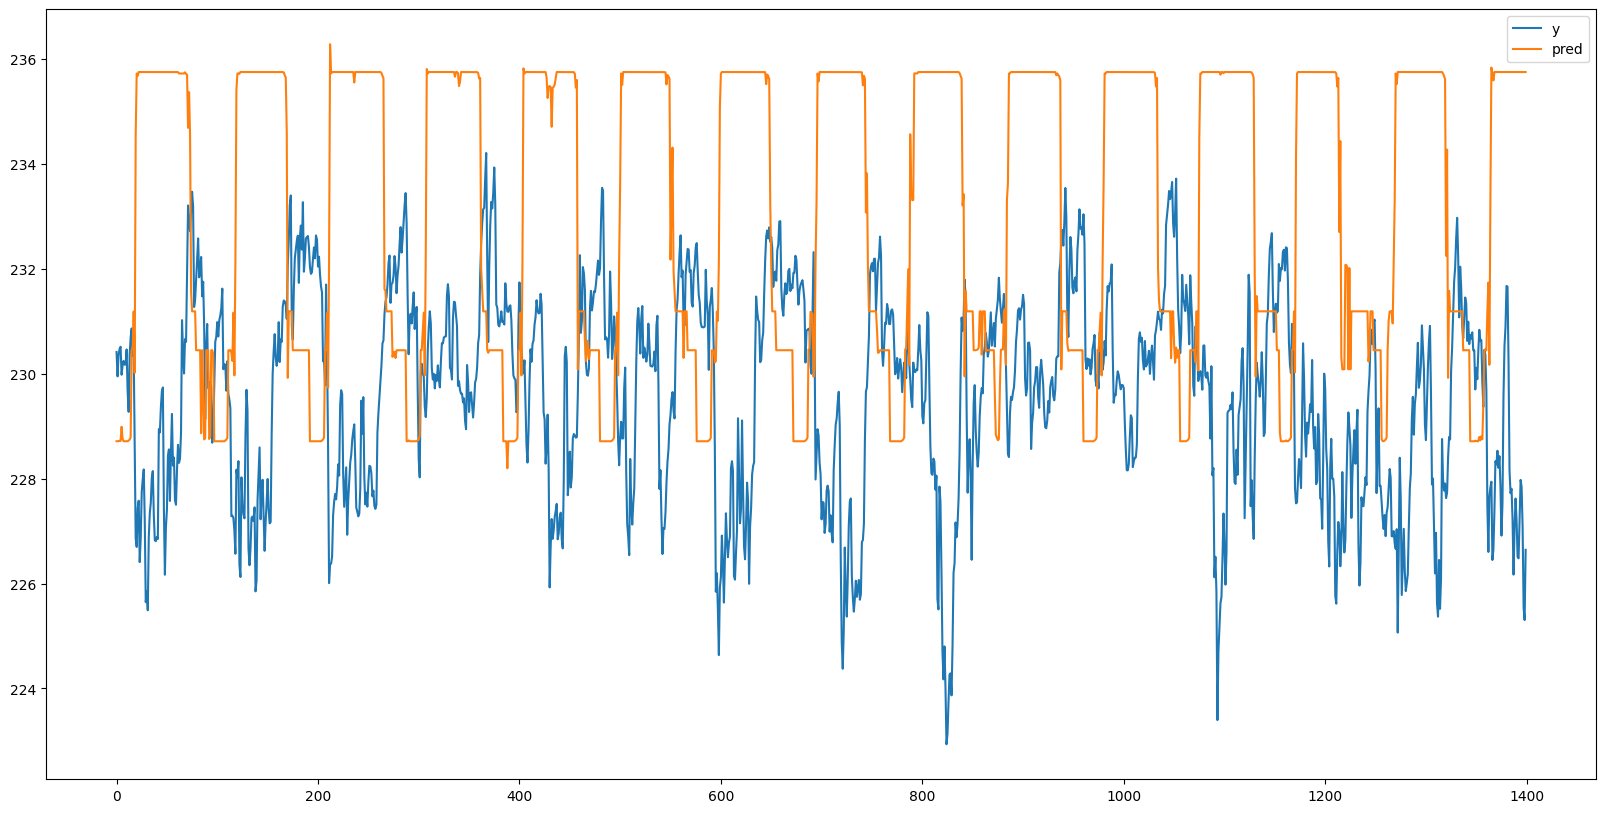

In [14]:
node = 50
pred_ind = 0

start = 0
len_measurements = 1400

plt.figure(figsize=(20,10))
plt.plot(ys[node,pred_ind,start:start+len_measurements], label="y")
plt.plot(preds[node,pred_ind,start:start+len_measurements], label="pred")
plt.legend()

In [15]:
#create txt file at name_txt
with open(name_txt, "w") as f:
    #print losses
    f.write("train losses:\n")
    f.write(str(losses_train))
    f.write("\n")
    f.write("eval losses:\n")
    f.write(str(losses_eval))
    f.write("\n")
    f.write("test loss:\n")
    f.write(str(loss_test))
    f.write("\n")
    f.write(str(loss_test_timewise))
    f.write("\n")
    f.write(str(loss_test_elementwise))
    f.write("\n")